# Regresion Logística 
_Odalys Yamilet Pimentel Juárez_

_Aprendizaje máquina_

## Introducción

### El objetivo del presente proyecto fue desarrollar un modelo de regresión lógística simple y múltiple para contrastar los resultados al predecir la popularidad de un conjunto de canciones, utilizando una base de datos obtenida del portal Kaggle. Para ello, se trabajó con un conjunto de registros relacionados con canciones de la artista Taylor Swift. Este tipo de modelos resulta útil para comprender cómo distintas características musicales pueden influir en el éxito de una canción.

## Datos

### La base de datos seleccionada proviene de Kaggle, con el título “Taylor Swift songs dataset” (https://www.kaggle.com/datasets/jarredpriester/taylor-swift-spotify-dataset/data). 
### Dicha base contiene diversas variables musicales por cada canción, tales como valence, energy, danceability, acousticness, entre otras. La variable objetivo definida fue popularity, la cual representa la medida del éxito de cada canción. Anteriormente trabajamos con este data set para realizar una regresión lineal, sin embargo la calidad del modelo fue deficiente, por lo cual se decidió intentarlo ahora con un modelo de regresión logística. 

In [1]:
##Librerías
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [2]:
# Leemos el dataset: 
df=pd.read_csv('taylor_swift_spotify.csv', index_col=0)

In [3]:
#Muestra de información sobre el df
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 582 entries, 0 to 581
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              582 non-null    object 
 1   album             582 non-null    object 
 2   release_date      582 non-null    object 
 3   track_number      582 non-null    int64  
 4   id                582 non-null    object 
 5   uri               582 non-null    object 
 6   acousticness      582 non-null    float64
 7   danceability      582 non-null    float64
 8   energy            582 non-null    float64
 9   instrumentalness  582 non-null    float64
 10  liveness          582 non-null    float64
 11  loudness          582 non-null    float64
 12  speechiness       582 non-null    float64
 13  tempo             582 non-null    float64
 14  valence           582 non-null    float64
 15  popularity        582 non-null    int64  
 16  duration_ms       582 non-null    int64  
dtypes:

In [4]:
# Revisamos rápidamente si existen valores nulos en el dataframe
conteo_nulos_por_columna = df.isnull().sum()
print("\nNúmero de valores nulos por columna:")
print(conteo_nulos_por_columna)


Número de valores nulos por columna:
name                0
album               0
release_date        0
track_number        0
id                  0
uri                 0
acousticness        0
danceability        0
energy              0
instrumentalness    0
liveness            0
loudness            0
speechiness         0
tempo               0
valence             0
popularity          0
duration_ms         0
dtype: int64


In [5]:
#Me tompe el tiempo de revisar la columna album para aliminar aquellas filas que sólo estuvieran haciendo 'ruido'
##y que no fueran relevantes para nuestro entrenamientno
df['album'].value_counts()

album
reputation Stadium Tour Surprise Song Playlist                                         46
folklore: the long pond studio sessions (from the Disney+ special) [deluxe edition]    34
THE TORTURED POETS DEPARTMENT: THE ANTHOLOGY                                           31
Red (Taylor's Version)                                                                 30
Fearless (Taylor's Version)                                                            26
Midnights (The Til Dawn Edition)                                                       23
1989 (Taylor's Version) [Deluxe]                                                       22
Speak Now (Taylor's Version)                                                           22
Red (Deluxe Edition)                                                                   22
Speak Now (Deluxe Package)                                                             22
1989 (Taylor's Version)                                                                21
Midn

In [6]:
# eliminamos las columnas que nos hacen ruido, muchas veces son segundas versiones o canciones en vivo)
df2 = df[~df['album'].str.contains("Live")]
df2 = df2[~df2['album'].str.contains("Tour")]
df2 = df2[~df2['album'].str.contains("International")]
df2 = df2[~df2['album'].str.contains("Platinum")]
#df2 = df2[~df2['album'].str.contains("Deluxe")]
df2['album'].value_counts()

album
folklore: the long pond studio sessions (from the Disney+ special) [deluxe edition]    34
THE TORTURED POETS DEPARTMENT: THE ANTHOLOGY                                           31
Red (Taylor's Version)                                                                 30
Fearless (Taylor's Version)                                                            26
Midnights (The Til Dawn Edition)                                                       23
1989 (Taylor's Version) [Deluxe]                                                       22
Speak Now (Taylor's Version)                                                           22
Speak Now (Deluxe Package)                                                             22
Red (Deluxe Edition)                                                                   22
1989 (Taylor's Version)                                                                21
Midnights (3am Edition)                                                                20
1989

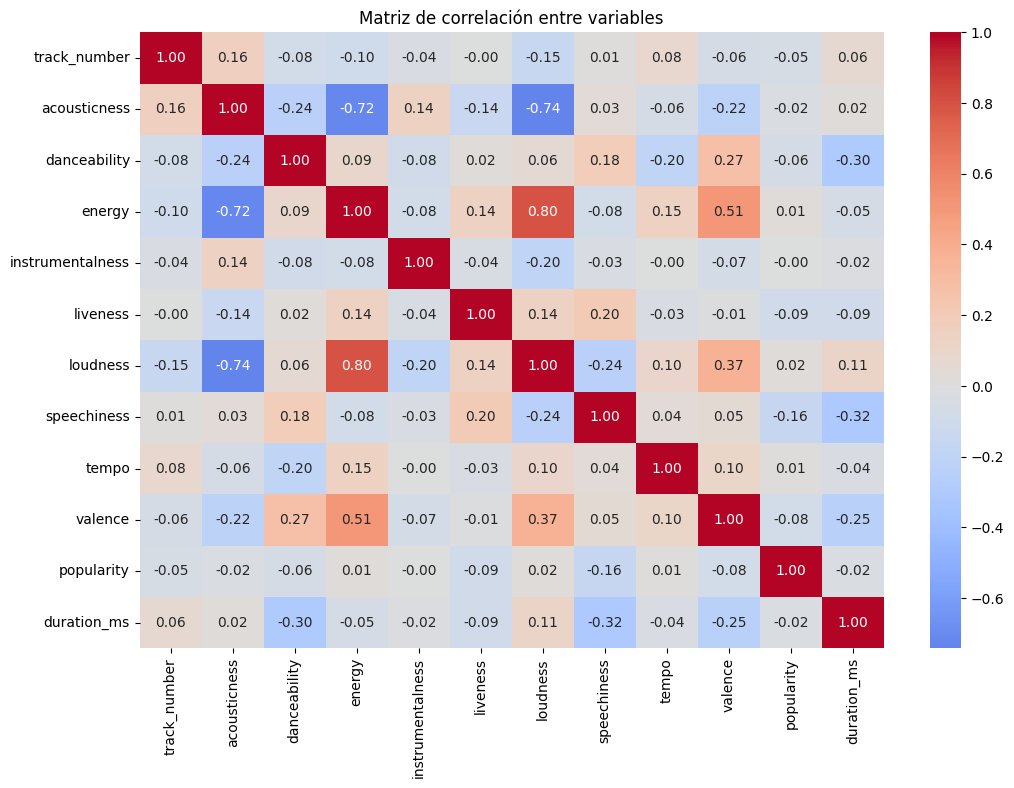

In [7]:
#Se realizó un mapa de calor para saber que variable influye más con popularidad
correlation_matrix = df2.select_dtypes(include='number').corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Matriz de correlación entre variables")
plt.show()


Observamos que energy, loudness y tempo tienen una correlación apenas perceptible, más adelante averiguaremos si la combinación de estos puede lograr un modelo de predicción de calidad

Text(0.5, 1.0, 'Cleaned Popularity')

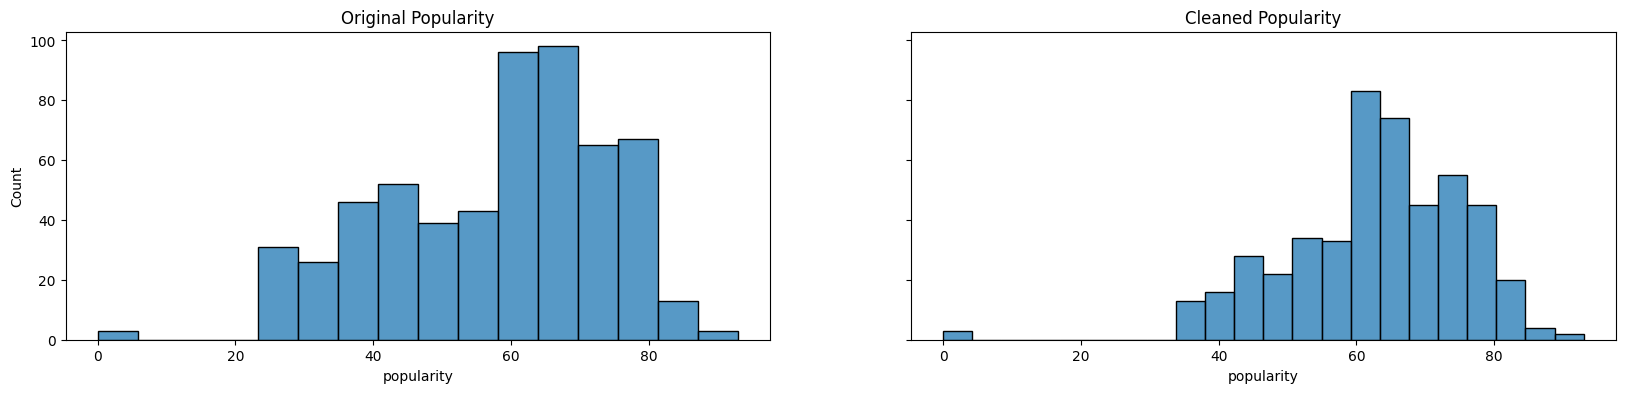

In [8]:
#Mostramos gráficaas de la distribución de la popularidad vs la cantidad de canciones
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,4), sharey=True)

sns.histplot(df["popularity"],bins='auto', ax=axes[0])
sns.histplot(df2["popularity"],bins='auto', ax=axes[1])

axes[0].set_title('Original Popularity')
axes[1].set_title('Cleaned Popularity')

In [9]:
#Mostramos una breve descripción de la columna después de aplicarle limpieza
df2['popularity'].describe()

count    477.000000
mean      62.828092
std       12.879851
min        0.000000
25%       55.000000
50%       64.000000
75%       72.000000
max       93.000000
Name: popularity, dtype: float64

## Selección de la variable objetivo

### Para la construcción del modelo, se seleccionó como variable objetivo la característica popularity, ya que esta representa el grado de éxito de una canción y puede interpretarse como el resultado de distintos factores musicales. Para esto se añadió una nueva columna categórica 'IsPopular' que determinara si una canción es popular o no, con un umbral de 62 siguiendo la distribución mostrada en las gráficas anteriores. ¶

In [10]:

# Define el umbral
threshold = 62

# Crea la columna 'IsPopular' 
df2['IsPopular'] = df2['popularity'].apply(lambda x: 1 if x >= threshold else 0)

# Revisión
print(df2[['popularity', 'IsPopular']].head())


   popularity  IsPopular
0          82          1
1          79          1
2          80          1
3          82          1
4          80          1


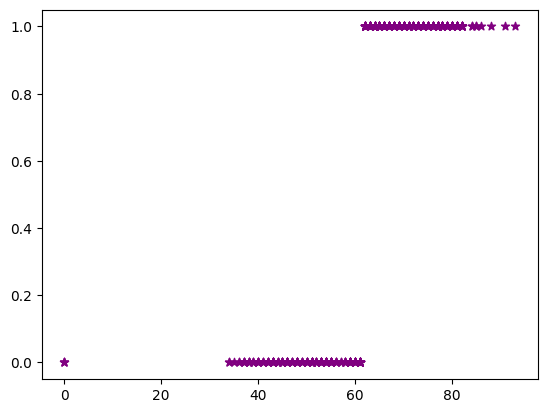

In [11]:
plt.scatter(df2.popularity, df2.IsPopular, marker= '*', color='purple')

## Variables descriptivas


### Las columnas restantes serán utilizadas como variables descriptivas en modelos de regresión logística. Escoger 3 de estas variables y, para cada una:
a. Entrenar un modelo de regresión logística simple, utilizando la base de entrenamiento (realizar un gráfico de la dispersión de los puntos).

b. Utilizar el modelo entrenado para hacer predicciones en la base de prueba.

c. Obtener la matriz de confusión y obtener el reporte de clasificación.

d. Dar conclusiones sobre qué quiere decir la exactitud, presición y recall obtenidos, en términos del problema que se está estudiando.

#### a) Modelo de regresión logística simple: _*Popularidad según la energía*_

In [12]:
#Separamos los datos de entrenamiento y los de prueba
X_train, X_test, y_train, y_test=train_test_split(df2[['energy']], df2.IsPopular, train_size=0.95,random_state=42)
model=LogisticRegression(class_weight='balanced')

In [13]:
#Ajustamos el modelo
model.fit(X_train,y_train)

LogisticRegression(class_weight='balanced')

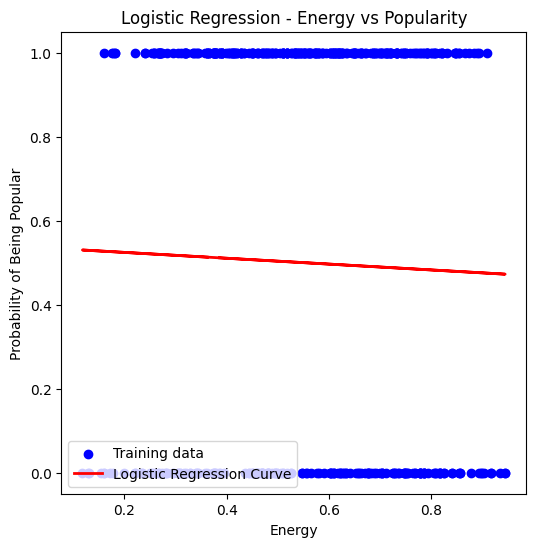

In [14]:
#Gráfico de dispeersión 
plt.figure(figsize=(6,6))
plt.scatter(X_train, y_train, color='blue', label='Training data')
plt.plot(X_train, model.predict_proba(X_train)[:,1], color='red', linewidth=2, label='Logistic Regression Curve')
plt.xlabel('Energy')
plt.ylabel('Probability of Being Popular')
plt.title('Logistic Regression - Energy vs Popularity')
plt.legend()
plt.show()

Tendencia General:

La curva de regresión logística muestra una ligera tendencia descendente. Esto sugiere que, según este modelo, a medida que la energía de una canción aumenta, la probabilidad de que sea popular disminuye muy ligeramente. Sin embargo, la relación no es muy pronunciada.

Dispersión de los Datos:

Los puntos de datos (que representan canciones) están bastante dispersos. Se puede ver que hay canciones con baja energía que son tanto populares (1) como no populares (0), y lo mismo ocurre con las canciones de alta energía.

### b) Utilizar el modelo entrenado para hacer predicciones en la base de prueba..

In [15]:
testing=model.predict(X_test)
testing

array([0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 0], dtype=int64)

### c) Obtener la matriz de confusión y obtener el reporte de clasificación.

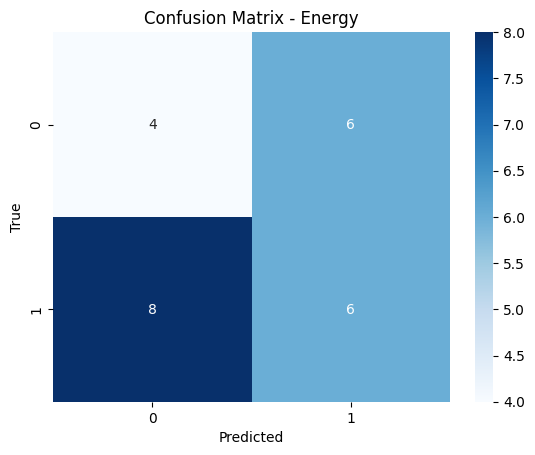

In [16]:
cm = confusion_matrix(y_test, testing)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title('Confusion Matrix - Energy')
plt.show()

In [17]:
# Reporte de clasificación
print(classification_report(y_test, testing))

              precision    recall  f1-score   support

           0       0.33      0.40      0.36        10
           1       0.50      0.43      0.46        14

    accuracy                           0.42        24
   macro avg       0.42      0.41      0.41        24
weighted avg       0.43      0.42      0.42        24



### d) Conclusiones
Exactitud

Tu modelo acierta en el 42% de los casos. Es decir, si predices si una canción será popular o no basándote en la energía, solo acertarías un poco menos de la mitad de las veces, la energía por sí sola no es un predictor muy bueno de la popularidad.

Recall:

Para las canciones no populares, el recall es 40%: el modelo logra encontrar correctamente 4 de cada 10 canciones no populares.

Para las canciones populares, el recall es 43%: el modelo detecta 4 de cada 10 canciones populares. ➔ Conclusión: el modelo está dejando pasar más de la mitad de las canciones correctas, tanto populares como no populares.

F1-score:
Combinando precisión y recall, el F1-score promedio ponderado es 0.42, lo que confirma que el desempeño general del modelo es bajo..


--------------------------------------------------------------------------------

### a) Modelo de regresión logística simple: _*Popularidad según el tempo*_

In [18]:
#Separamos los datos de entrenamiento y los de prueba
X_train, X_test, y_train, y_test=train_test_split(df2[['tempo']], df2.IsPopular, train_size=0.80,random_state=42)

In [19]:
#ajustamos el modelo
model=LogisticRegression(class_weight='balanced')
model.fit(X_train,y_train)

LogisticRegression(class_weight='balanced')

#### b) Utilizar el modelo entrenado para hacer predicciones en la base de prueba.

In [20]:
testing=model.predict(X_test)
testing

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 1, 0], dtype=int64)

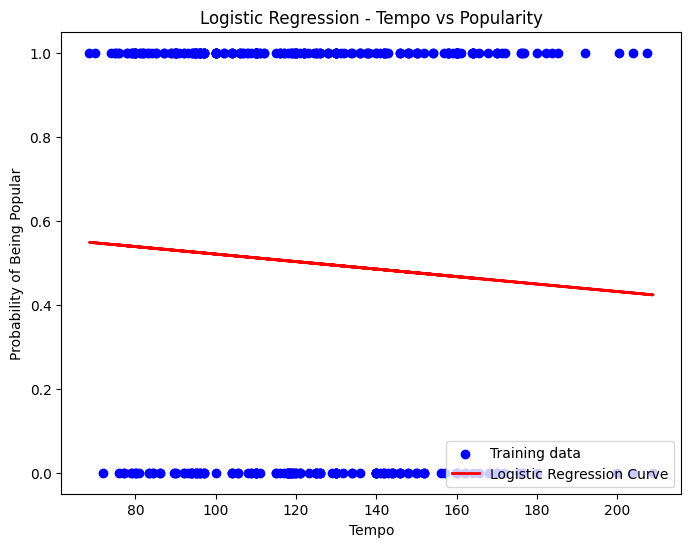

In [21]:
#gráfico de dispersión del Tempo
plt.figure(figsize=(8,6))
plt.scatter(X_train, y_train, color='blue', label='Training data')
plt.plot(X_train, model.predict_proba(X_train)[:,1], color='red', linewidth=2, label='Logistic Regression Curve')
plt.xlabel('Tempo')
plt.ylabel('Probability of Being Popular')
plt.title('Logistic Regression - Tempo vs Popularity')
plt.legend()
plt.show()

Tendencia General:

La curva de regresión logística muestra una ligera tendencia descendente. Esto sugiere que, según este modelo, a medida que el tempo de una canción aumenta, la probabilidad de que sea popular disminuye muy ligeramente. Sin embargo, la relación no es muy pronunciada.

Dispersión de los Datos:

Los puntos de datos (que representan canciones) están bastante dispersos. Se puede ver que hay canciones con tempo desde 80 hasta más de 200. 

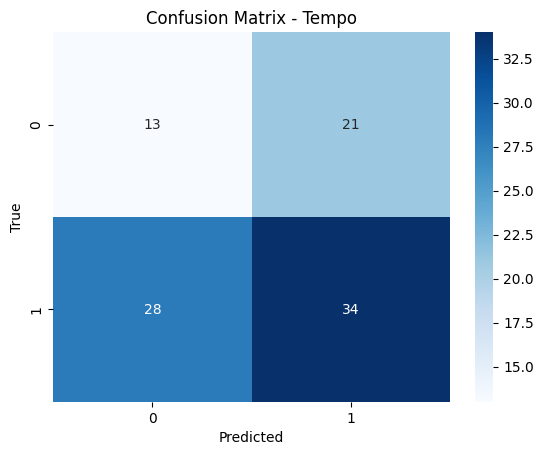

In [22]:
# Diagrma de confusión y Reporte de clasificación
cm = confusion_matrix(y_test, testing)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title('Confusion Matrix - Tempo')
plt.show()

In [23]:
# Reporte de clasificación
print(classification_report(y_test, testing))

              precision    recall  f1-score   support

           0       0.32      0.38      0.35        34
           1       0.62      0.55      0.58        62

    accuracy                           0.49        96
   macro avg       0.47      0.47      0.46        96
weighted avg       0.51      0.49      0.50        96



### d) Conclusiones
Exactitud 

El modelo acierta en el 49% de las predicciones. Esto es prácticamente como lanzar una moneda al aire indicando que el tempo, usado solo, tampoco es suficiente para predecir bien la popularidad.

Precisión:

Para canciones no populares (clase 0), la precisión es 32%, es decir, de todas las veces que el modelo dice que una canción no será popular, solo 3 de cada 10 predicciones son correctas.

Para canciones populares (clase 1), la precisión sube a 62%, lo que significa que cuando el modelo predice que una canción es popular, acierta casi 2 de cada 3 veces. El modelo es mejor reconociendo canciones populares que no populares, pero aun así no es muy confiable.

Recall:

Para canciones no populares, el recall es 38%, es decir, solo detecta correctamente 4 de cada 10 canciones no populares. Para canciones populares, el recall es 55%, o sea, reconoce un poco más de la mitad de las canciones populares. Aunque el modelo detecta un poco más las canciones populares, todavía omite muchas.

F1-score:
El F1-score promedio ponderado es 0.50, indicando un desempeño bajo-moderado (pero mejor que usando energía sola).

----------------------------------------------

### a) Modelo de regresión logística simple: _*Popularidad según loudness*_

In [24]:
X_train, X_test, y_train, y_test=train_test_split(df2[['loudness']], df2.IsPopular, train_size=0.90,random_state=42)
model=LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42)
model.fit(X_train,y_train)

LogisticRegression(class_weight='balanced', random_state=42, solver='liblinear')

#### b) Utilizar el modelo entrenado para hacer predicciones en la base de prueba.

In [25]:
testing=model.predict(X_test)
testing

array([0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 0], dtype=int64)

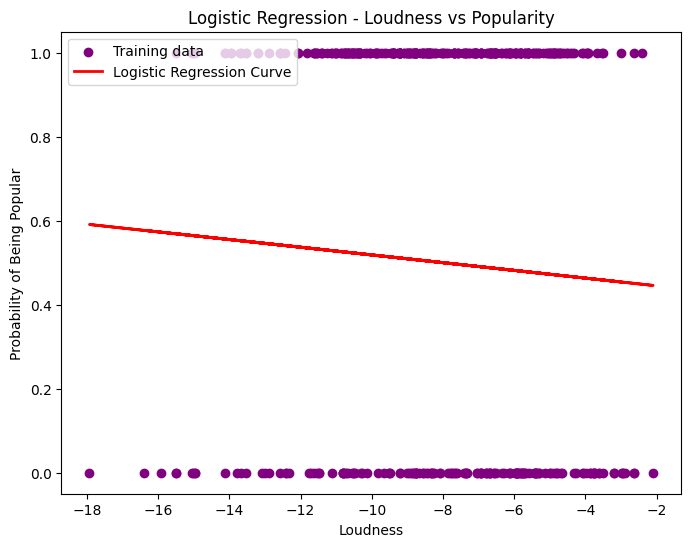

In [26]:
#grafico de dispersipon de loudness
plt.figure(figsize=(8,6))
plt.scatter(X_train, y_train, color='purple', label='Training data')
plt.plot(X_train, model.predict_proba(X_train)[:,1], color='red', linewidth=2, label='Logistic Regression Curve')
plt.xlabel('Loudness')
plt.ylabel('Probability of Being Popular')
plt.title('Logistic Regression - Loudness vs Popularity')
plt.legend()
plt.show()

Aunque el modelo de regresión logística encuentra una ligera relación negativa entre loudness y popularidad, la dispersión de los datos muestra que loudness por sí sola no es un buen predictor de si una canción será popular o no. La relación es débil y los datos están muy mezclados en términos de popularidad.

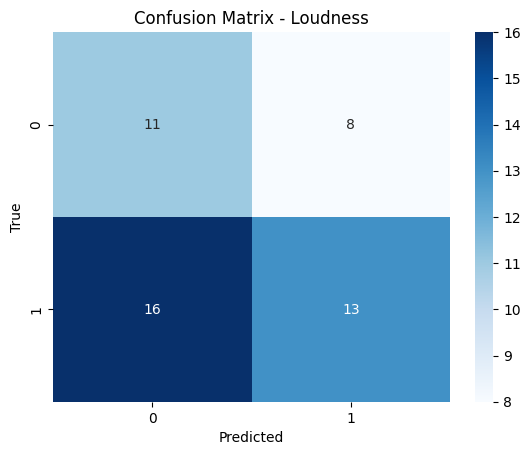

In [27]:
# Diagrma de confusión y Reporte de clasificación
cm = confusion_matrix(y_test, testing)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title('Confusion Matrix - Loudness')
plt.show()

In [28]:
# Reporte de clasificación
print(classification_report(y_test, testing))

              precision    recall  f1-score   support

           0       0.41      0.58      0.48        19
           1       0.62      0.45      0.52        29

    accuracy                           0.50        48
   macro avg       0.51      0.51      0.50        48
weighted avg       0.54      0.50      0.50        48



### d) Conclusiones
Exactitud


Lo mismo que sucedió en la variable pasada, el modelo acierta en %50 , equivalente a lanzar una moneda al azar.

Precisión:

Para canciones no populares (clase 0), la precisión es 41%: cuando predice que una canción no es popular, solo 4 de cada 10 veces acierta.

Para canciones populares (clase 1), la precisión es 62%: si predice que una canción es popular, 6 de cada 10 veces acierta.

Recall:

Para canciones no populares, el recall es 58%: detecta correctamente casi 6 de cada 10 canciones no populares. Para canciones populares, el recall es 45%: menos de la mitad de las canciones populares son identificadas correctamente. El modelo es ligeramente mejor reconociendo canciones no populares que populares en términos de recall, aunque con precisión baja.

F1-score: El F1-score promedio ponderado es 0.50, refleja un desempeño global bajo-moderadao.

---------------------------------------------------

## Modelo de regresion logística múltiple

### Entrenamos el modelo con las columnas descriptivas de interés

In [29]:
#columnas de interés
features = ['energy', 'loudness', 'tempo']

X = df2[features]
y = df2['IsPopular']
X_train_mul, X_test_mul, y_train_mul, y_test_mul = train_test_split(X, y, train_size=0.80, random_state=42)



In [30]:
#  Inicializa y entrena el modelo de regresión logística
#    Puedes ajustar el parámetro 'solver' según la naturaleza de tus datos.

model_multi = LogisticRegression(class_weight='balanced',solver='liblinear', random_state=42)
model_multi.fit(X_train_mul, y_train_mul)

LogisticRegression(class_weight='balanced', random_state=42, solver='liblinear')

In [31]:
y_pred_multi = model_multi.predict(X_test_mul)
y_pred_multi

array([0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 0], dtype=int64)

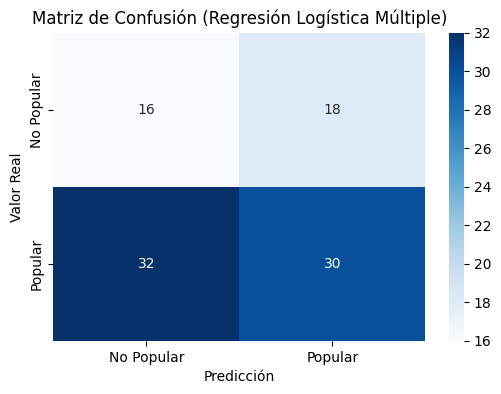

In [32]:
## Diagrma de confusión y Reporte de clasificación
cm_multi = confusion_matrix(y_test_mul, y_pred_multi)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_multi, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Popular', 'Popular'], yticklabels=['No Popular', 'Popular'])
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión (Regresión Logística Múltiple)')
plt.show()

In [33]:
# 5. Evalúa el rendimiento del modelo
accuracy = accuracy_score(y_test_mul, y_pred_multi)
print(f'Precisión del modelo de regresión logística múltiple: {accuracy:.2f}')

print('\nInforme de clasificación:')
print(classification_report(y_test_mul, y_pred_multi))

Precisión del modelo de regresión logística múltiple: 0.48

Informe de clasificación:
              precision    recall  f1-score   support

           0       0.33      0.47      0.39        34
           1       0.62      0.48      0.55        62

    accuracy                           0.48        96
   macro avg       0.48      0.48      0.47        96
weighted avg       0.52      0.48      0.49        96



### Conclusiones
Los modelos de regresión logística simple, basados en energía, tempo y loudness como predictores individuales de la popularidad de las canciones, mostraron desempeños limitados. En todos los casos, las exactitudes fueron bajas (alrededor de 42%–50%), y las métricas de precisión y recall indicaron que no existe una relación fuerte entre estas variables individuales y la popularidad. 

El modelo de regresión logística múltiple, que combinó las mismas 3 variables, tampoco logró una mejora significativa: obtuvo una exactitud de 48%, una precisión de 62% para canciones populares y de 33% para no populares, y un f1-score ponderado de 0.49.

En conjunto, los resultados indican que, tanto de manera individual como combinada, las variables consideradas no explican suficientemente la popularidad de una canción mediante un modelo lineal simple como la regresión logística. Se recomienda considerar otros enfoques, como modelos no lineales (Random Forests, SVM o XGBoost) o la incorporación de nuevas variables que capturen mejor la complejidad del fenómeno.